In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union
import pandas as pd

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from src.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score, denoise
from src.sampling_utils import random_step, langevin_step, repulsive_step_parallel
from src.kernel import RBF
from src.embedding import CNN64, CNN16, init_weights, AverageDim, Average, VAEAverage, Style, VGG, VGG_dropout, VGG_noise
from src.datasets import StyleDataset, ArtistDataset
from src.train import train

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from collections import deque
from torch.utils.data import DataLoader, Dataset, random_split
from glob import glob

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**FID**
- Comparison of max diversity and query set of samples
- Get distribution of FID vectors for each set + fit gaussian
- Frechet distance between gaussians

In [2]:
# Read image sets
img_dir = ""
f = []
for file in glob("data/styles/artists/Thomas_Kinkade/*.png"):
    f.append(file)

In [36]:
fid_dir = "fid" #/pt_inception-2015-12-05-6726825d.pth"
dims = 192  # 64, 192, 768, 2048
device = 'cuda'
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx], model_dir=fid_dir).to(device)
# m, s = calculate_activation_statistics(f, model, 8, dims, device)

act = get_activations(f, model, 50, dims, device, None)

# save_statistics("data/styles/artists/fid_all.npz",m,s)

# load precomputed m, s
# path = os.path.join(fid_dir, args.dataset + '.npz')
# m0, s0 = load_statistics(path)

# fid = calculate_frechet_distance(m0, s0, m, s)

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.


In [37]:
act.shape

(100, 192, 35, 35)

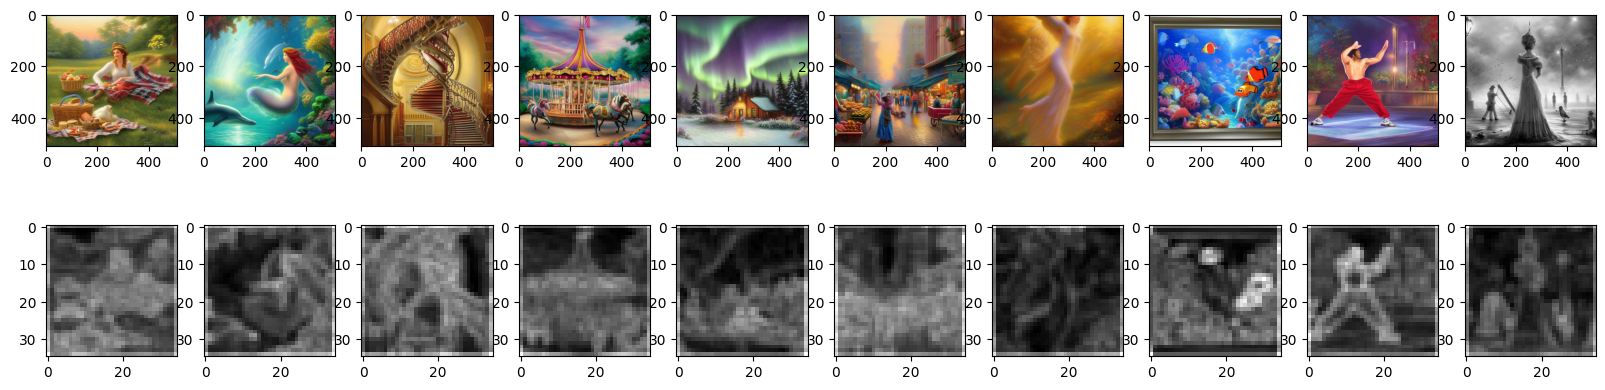

In [38]:
mean_act = np.mean(act,axis=1)
n=10
plt.figure(figsize=(20,5))
for i in range(n):
    img = Image.open(f[50+i])
    plt.subplot(2,n,i+1)
    plt.imshow(img)
    plt.subplot(2,n,n + i + 1)
    plt.imshow(mean_act[50+i], cmap='gray')

In [10]:
# Get FID of each artist's images
for f in glob("data/styles/artists/*"):
    imgs = []
    for imgf in glob(f"{f}/*.png"):
        imgs.append(imgf)
    print(len(imgs))
    m, s = calculate_activation_statistics(imgs, model, 8, dims, device)
    save_statistics(f"{f}/fid.npz",m,s)

100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
100
Starting to sample.
0


ValueError: batch_size should be a positive integer value, but got batch_size=0

In [24]:
# m, s = load_statistics("data/styles/artists/fid_all.npz")
m0, s0 = load_statistics("data/styles/artists/Winslow_Homer/fid.npz")
m, s = load_statistics("data/styles/artists/Walt_Disney/fid.npz")
# m, s = load_statistics("data/apple_fid.npz")
# m0, s0 = load_statistics("data/fruits_fid.npz")
fid = calculate_frechet_distance(m0, s0, m, s)

In [25]:
fid

190.96321026820573

In [ ]:
m, s = load_statistics("data/apple_white_adjectives_fid.npz")

In [ ]:
# Plot images from dataset
import glob
n=2
images = []
for folder in glob.glob("data/fruit/*"):
    i=0
    for file in glob.glob(os.path.join(folder,"*")):
        if i<n:
            images.append(Image.open(file))
            i+=1

grid = image_grid(images, rows=n, cols=10)

